In [ ]:
import pandas as pd
import re
import spacy
from collections import defaultdict, Counter
from nltk.corpus import stopwords
import stopwords as stw
from wordcloud import STOPWORDS as wc_stopwords
from nltk.util import ngrams


# Load the datasets
train_data = pd.read_csv('train.tsv', sep='\t', header=None, names=["Text", "Label"]).iloc[1:].reset_index(drop=True)
valid_data = pd.read_csv('valid.tsv', sep='\t', header=None, names=["Text", "Label"]).iloc[1:].reset_index(drop=True)

# Preprocess text function

# Load SpaCy's English model
nlp = spacy.load('en_core_web_sm')

# Get stopwords from different libraries
nltk_stopwords = set(stopwords.words('english'))  # NLTK stopwords
spacy_stopwords = nlp.Defaults.stop_words  # SpaCy stopwords
custom_stopwords = stw.get_stopwords('en')  # Stopwords from the 'stopwords' library
wordcloud_stopwords = wc_stopwords  # Stopwords from Wordcloud library

# Combine all stopwords into a single set (for efficiency)
stop_words = nltk_stopwords.union(spacy_stopwords).union(custom_stopwords).union(wordcloud_stopwords)
print(f'Number of stopwords: {len(stop_words)}')
def preprocess_text(text):
    text = text.lower()  
    # Remove Unicode escape sequences
    text = re.sub(r'\\u[0-9a-fA-F]{4}', '', text)
    # Remove words starting with special characters
    text = re.sub(r'\B[@#]\w+', '', text)
    # Tokenize by words and remove non-alphabetic characters
    tokens = re.findall(r'\b[a-z]+\b', text)
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Generate n-grams (using bigrams as an example here)
    ngrams_tokens = list(ngrams(filtered_tokens, 1))  # Unigrams here; change to (2) for bigrams, etc.
    
    # Convert n-grams tuples to strings for easier readability
    ngrams_tokens = [' '.join(gram) for gram in ngrams_tokens]
    
    return ngrams_tokens

# Apply preprocessing with stop word removal
train_data['Tokens'] = train_data['Text'].apply(preprocess_text)
valid_data['Tokens'] = valid_data['Text'].apply(preprocess_text)



Number of stopwords: 420


In [96]:
# Count the number of documents per class
class_counts = train_data['Label'].value_counts()
total_docs = len(train_data)
print('class counts:', class_counts)
print('total docs:', total_docs)
# Calculate class priors P(class)
class_priors = {}
for cls, count in class_counts.items():
    class_priors[cls] = count / total_docs
print('class priors:', class_priors)
# Word counts for each class
word_counts = defaultdict(Counter)
total_words_in_class = defaultdict(int)

# Populate word counts per class
for _, row in train_data.iterrows():
    label = row['Label']
    tokens = row['Tokens']
    word_counts[label].update(tokens)
    total_words_in_class[label] += len(tokens)
print('word counts:', word_counts)
print('total words in class:', total_words_in_class)

# Vocabulary size
vocabulary = set()
for words in word_counts.values():
    for word in words:
        vocabulary.add(word)
vocab_size = len(vocabulary)
print('vocabulary:', vocabulary)
print('vocab size:', vocab_size)

# Calculate word likelihoods with Laplace smoothing
word_likelihoods = defaultdict(dict)
for cls, counts in word_counts.items():
    for word in vocabulary:
        word_likelihoods[cls][word] = (counts[word] + 1) / (total_words_in_class[cls] + vocab_size)
print('word likelihoods:', word_likelihoods)

class counts: Label
negative    613
neutral     613
positive    613
Name: count, dtype: int64
total docs: 1839
class priors: {'negative': 0.3333333333333333, 'neutral': 0.3333333333333333, 'positive': 0.3333333333333333}
word counts: defaultdict(<class 'collections.Counter'>, {'negative': Counter({'tomorrow': 87, 'going': 45, 'night': 33, 'day': 33, 'sunday': 32, 'time': 30, 'think': 28, 'world': 23, 'sat': 21, 'monday': 20, 'new': 19, 'muslims': 19, 'watch': 19, 'im': 18, 'amp': 18, 'want': 18, 'sun': 18, 'friday': 18, 'got': 18, 'u': 18, 'right': 17, 'game': 17, 'people': 17, 'obama': 16, 'play': 15, 'said': 15, 'gonna': 15, 'bad': 15, 'shit': 15, 'way': 15, 'cant': 14, 'season': 14, 'today': 14, 'lol': 14, 'thursday': 14, 'know': 14, 'sad': 14, 'dont': 13, 'yakub': 13, 'actually': 13, 'place': 12, 'fuck': 12, 'news': 12, 'jenner': 12, 'thing': 12, 'sorry': 11, 'wrong': 11, 'caitlyn': 11, 'west': 10, 'perry': 10, 'c': 10, 'need': 10, 'big': 10, 'saturday': 10, 'stop': 9, 'kanye': 9, 

In [97]:
# Naive Bayes classification
def classify_naive_bayes(tokens):
    class_scores = {}
    for cls in class_priors:
        # Start with the prior log probability of the class
        score = class_priors[cls]
        for token in tokens:
            # Multiply by word likelihood; add Laplace smoothing in case of missing words
            score *= word_likelihoods[cls].get(token, 1 / (total_words_in_class[cls] + vocab_size))
        class_scores[cls] = score
    
    # Return the class with the highest probability score
    return max(class_scores, key=class_scores.get)

# Classify the validation set
valid_data['Predicted'] = valid_data['Tokens'].apply(classify_naive_bayes)


In [98]:
# Calculate accuracy
accuracy = (valid_data['Predicted'] == valid_data['Label']).mean()
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 58.64%


In [99]:
# Display significant values
for cls in class_priors:
    print(f"Sample Word Likelihoods for '{cls}':")
    top_words = sorted(word_likelihoods[cls].items(), key=lambda x: x[1], reverse=True)[:100]
    for word, prob in top_words:
        print(f"  {word}: {prob:.5f}")
    print()


Sample Word Likelihoods for 'negative':
  tomorrow: 0.00738
  going: 0.00386
  day: 0.00285
  night: 0.00285
  sunday: 0.00277
  time: 0.00260
  think: 0.00243
  world: 0.00201
  sat: 0.00184
  monday: 0.00176
  watch: 0.00168
  new: 0.00168
  muslims: 0.00168
  friday: 0.00159
  got: 0.00159
  u: 0.00159
  want: 0.00159
  im: 0.00159
  sun: 0.00159
  amp: 0.00159
  people: 0.00151
  right: 0.00151
  game: 0.00151
  obama: 0.00142
  said: 0.00134
  way: 0.00134
  gonna: 0.00134
  bad: 0.00134
  play: 0.00134
  shit: 0.00134
  today: 0.00126
  sad: 0.00126
  season: 0.00126
  cant: 0.00126
  thursday: 0.00126
  lol: 0.00126
  know: 0.00126
  dont: 0.00117
  actually: 0.00117
  yakub: 0.00117
  thing: 0.00109
  place: 0.00109
  fuck: 0.00109
  news: 0.00109
  jenner: 0.00109
  caitlyn: 0.00101
  wrong: 0.00101
  sorry: 0.00101
  perry: 0.00092
  big: 0.00092
  west: 0.00092
  saturday: 0.00092
  need: 0.00092
  c: 0.00092
  hope: 0.00084
  sucks: 0.00084
  worst: 0.00084
  school: 0.0008

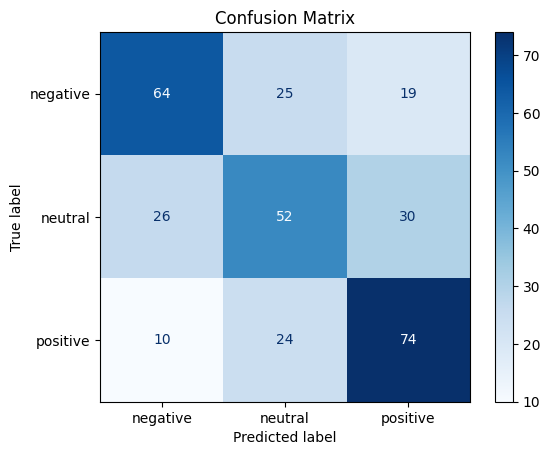

In [100]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ensure class_priors.keys() is converted to a list
class_labels = list(class_priors.keys())

# Calculate predictions
valid_data['Predicted'] = valid_data['Tokens'].apply(classify_naive_bayes)

# Compute confusion matrix
true_labels = valid_data['Label']  # Actual labels
predicted_labels = valid_data['Predicted']  # Predicted labels

# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=class_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
